# <center> Data Challenge Quantmetry - EDF

L'analyse et la mise en place du modèle finale s'articule autour du plan suivant:

    2. Introduction
    3. EDA - Consumption
    4. EDA - Meteo
        4.01 Missing values
        4.02 Correlation
        4.03 Jointplot
        4.04 Boxplot
    5. First Prediction - Quick & Dirty (Tabular Approach)
    6. Second Prediction - Deep Learning Approach
        6.01 Time Series Analytics
        6.02 Recurrent Neural Network
    7. Final Prediction - Stacking
        7.01 Stack 1
        7.02 Stack 2
        7.03 Stack 3
    

# Introduction

Jeu de données et évaluation des systèmes

Le but de ce challenge est de prévoir la consommation électrique de l’île d'Ouessant à 8 jours, en s’aidant des données suivantes :
- un an de données de consommation historiques, à la maille horaire (conso_train.csv),
- un an de données météorologiques à la maille tri-horaire, issues de la proche station météorologique de Brest (meteo_train.csv),
- une semaine de données météorologiques à la maille tri-horaire, issues de la même station et faisant office de prédiction météorologique (meteo_prev.csv).

Le principe est de considérer les prévisions météorologiques comme parfaites et de se placer dans le cadre défini par la figure ci-dessous pour prédire la consommation horaire sur une semaine :
Le critère d’évaluation de la qualité de prévision sera l’erreur absolue moyenne en pourcentage (MAPE).
En cas d’égalité au niveau de la MAPE, le jury utilisera l’erreur quadratique moyenne (RMSE) pour identifier la solution la plus performante.

L’introduction de jeux de données supplémentaires est autorisée, moyennant l'accord d'un des membres du jury, si cela peut avoir un intérêt dans la modélisation.
L’utilisation d’informations n’étant pas présentes dans les données est autorisée dans la mesure où il s’agit d’informations d’ordre général et publiques, permettant la création ou modification de variables à partir de données fournies.
À titre d’exemple, cela veut dire qu’il sera autorisé d’aller chercher des jours-fériés à la main, mais pas d’ajouter plus de données de consommation pour l’entrainement. N’hésitez pas à contacter le jury si vous avez un doute sur ce que vous avez le droit d’utiliser ou non. 

Règlement et inscription

Les équipes s'inscrivant au data challenge doivent être composées d'une à trois personnes.
Les solutions doivent être envoyées sous la forme d'un notebook agrémenté d'explications à l'adresse suivante datachallenge_jds2018@sfds.asso.fr. Le format notebook est encouragé par le jury mais un autre format tutoriel, avec explications à l'appui, sera accepté aussi. Il sera demandé en outre aux participants de fournir un code reproductible leur ayant permis d’obtenir leurs résultats à partir des données fournies, ainsi que leur vecteur de solution sous la forme d’un fichier .csv dont la forme est celle de conso_prev.csv (consommation horaire entre le 13/09/2016 00:00 et le 20/09/2016 23:00).

Le jury ne pourra juger que les rapports détaillés (codes fournis : R, python, matlab) et les explications claires.
Les organisateurs s'interdisent de tirer un profit des solutions proposées en les monétisant, autre que l'accroissement de la connaissance scientifique, qui est d'ailleurs à destination de tous ; les solutions restent propriété des auteurs.

Dates importantes

La compétition se déroulera de la manière suivante:

    Début des inscriptions : 30 Janvier 2018
    Clôture des inscriptions : 12 Février 2018
    Envoi du jeu de données : 17 Février 2018
    Début des soumissions : 19 Février 2018
    Fin des soumissions : 23 Avril 2018
    Publication des résultats : 14 Mai 2018
    Présentation : semaine du 28 Mai 2018


Prix

Un prix sera attribué à la meilleure prédiction. Les deux meilleures solutions s'engagent à présenter leurs productions lors de la session spéciale groupe "des Jeunes Statisticien.ne.s" organisée durant les 50ièmes Journées de Statistique à EDF Lab Saclay. En outre, les deux meilleurs groupes se verront proposer une soumission d'article résumant les travaux primés destinée à la revue CSBIGS de la SFdS.

Jury

    Luis Blanche, Quantmetry R&D
    Nicolas Bousquet, Quantmetry R&D
    Vincent Brault, Université Grenoble-Alpes
    Émilie Devijver, CNRS
    Yannig Goude, EDF R&D
    Raphaël Nédellec, EDF R&D


Organisateurs groupe Jeunes : Émilie Devijver et Valérie Robert

# EDA - Consumption

Dans cette première partie d'analyse nous allons nous concentrés sur le fichier conso_train.csv. Elle sera plutot orienté data visualisation. L'analyse a proprement parlé de la série temporelle sera vu dans la partie 6.01. La première cellule concerne l'import des package utilisées à travers notre analyse ainsi que quelques lignes de codes pour la présentation des graphiques et tableaux.

In [1]:
# Basics
import numpy as np 
import pandas as pd 
import random
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, HTML
from plotly.graph_objs import *
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
from ggplot import *

# Machine Learning
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet, HuberRegressor

# time series analysis
from scipy.signal import find_peaks_cwt
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep Learning
import tensorflow as tf

# Plot style
py.init_notebook_mode(connected=True)
init_notebook_mode(connected=True)
plt.style.use('ggplot')
    
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
color = sns.color_palette()

%matplotlib inline

# Import consumption (y_train)
train_conso = pd.read_csv('conso_train.csv',sep = ";")
train_conso['date'] = train_conso['date'].apply(lambda x: x.split('+')[0])
train_conso.drop_duplicates(inplace = True)
train_conso_plot = train_conso.set_index('date')
train_conso_plot.head()

,puissance
date,
2015-09-13T00:59:59,526.166667
2015-09-13T01:59:59,495.000000
2015-09-13T02:59:59,446.166667
2015-09-13T03:59:59,365.833333
2015-09-13T04:59:59,341.000000


Le premier fichier (conso_train.csv) comporte la date et la puissance associé. Pour rappel: la période étudiée est 13/09/2015 jusqu'au 20/09/2016.

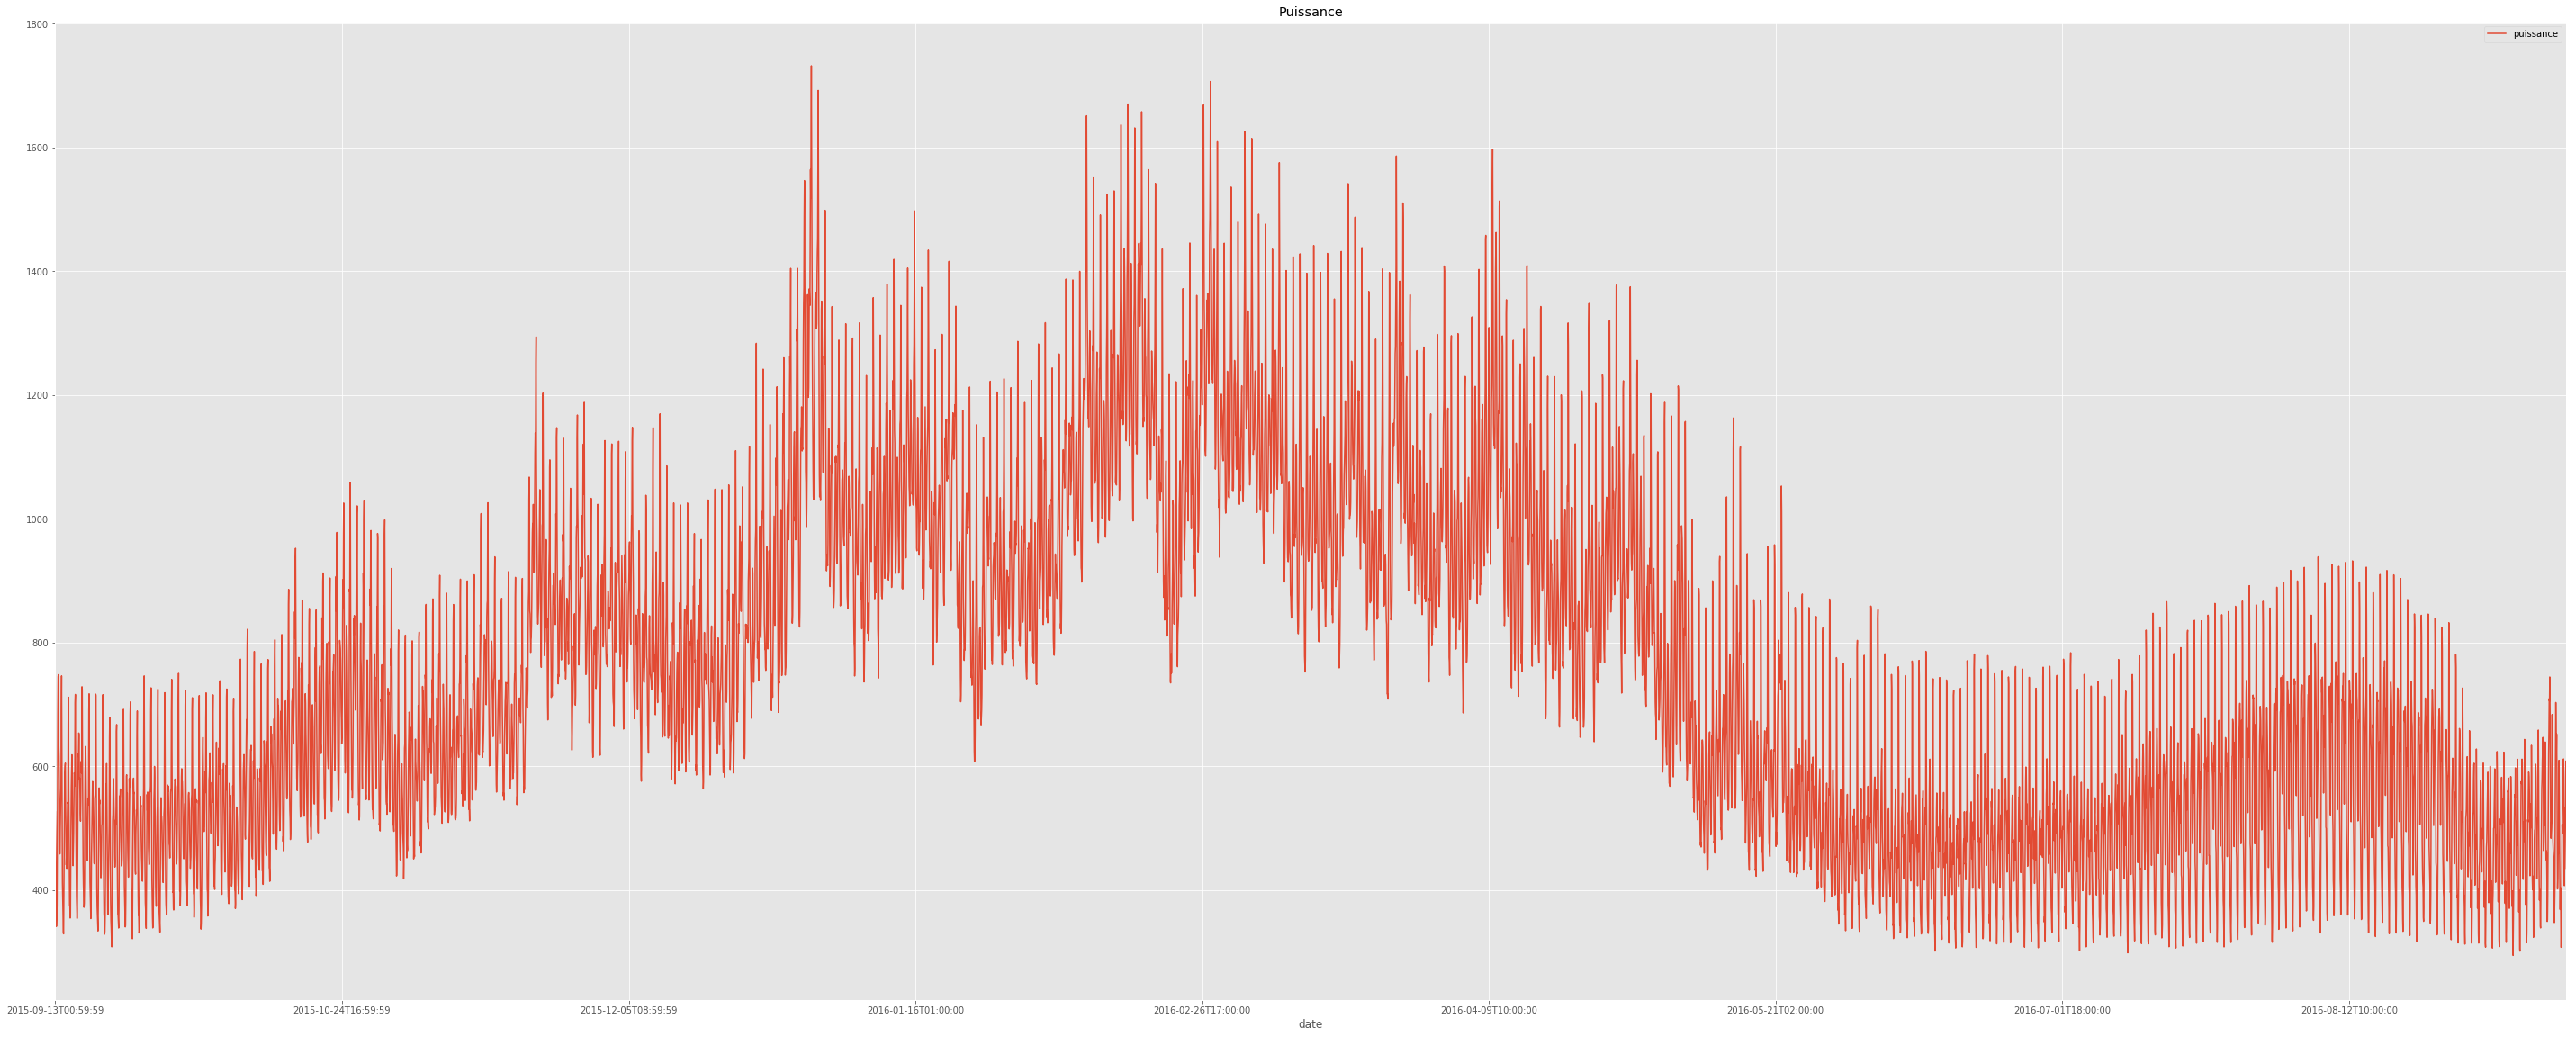

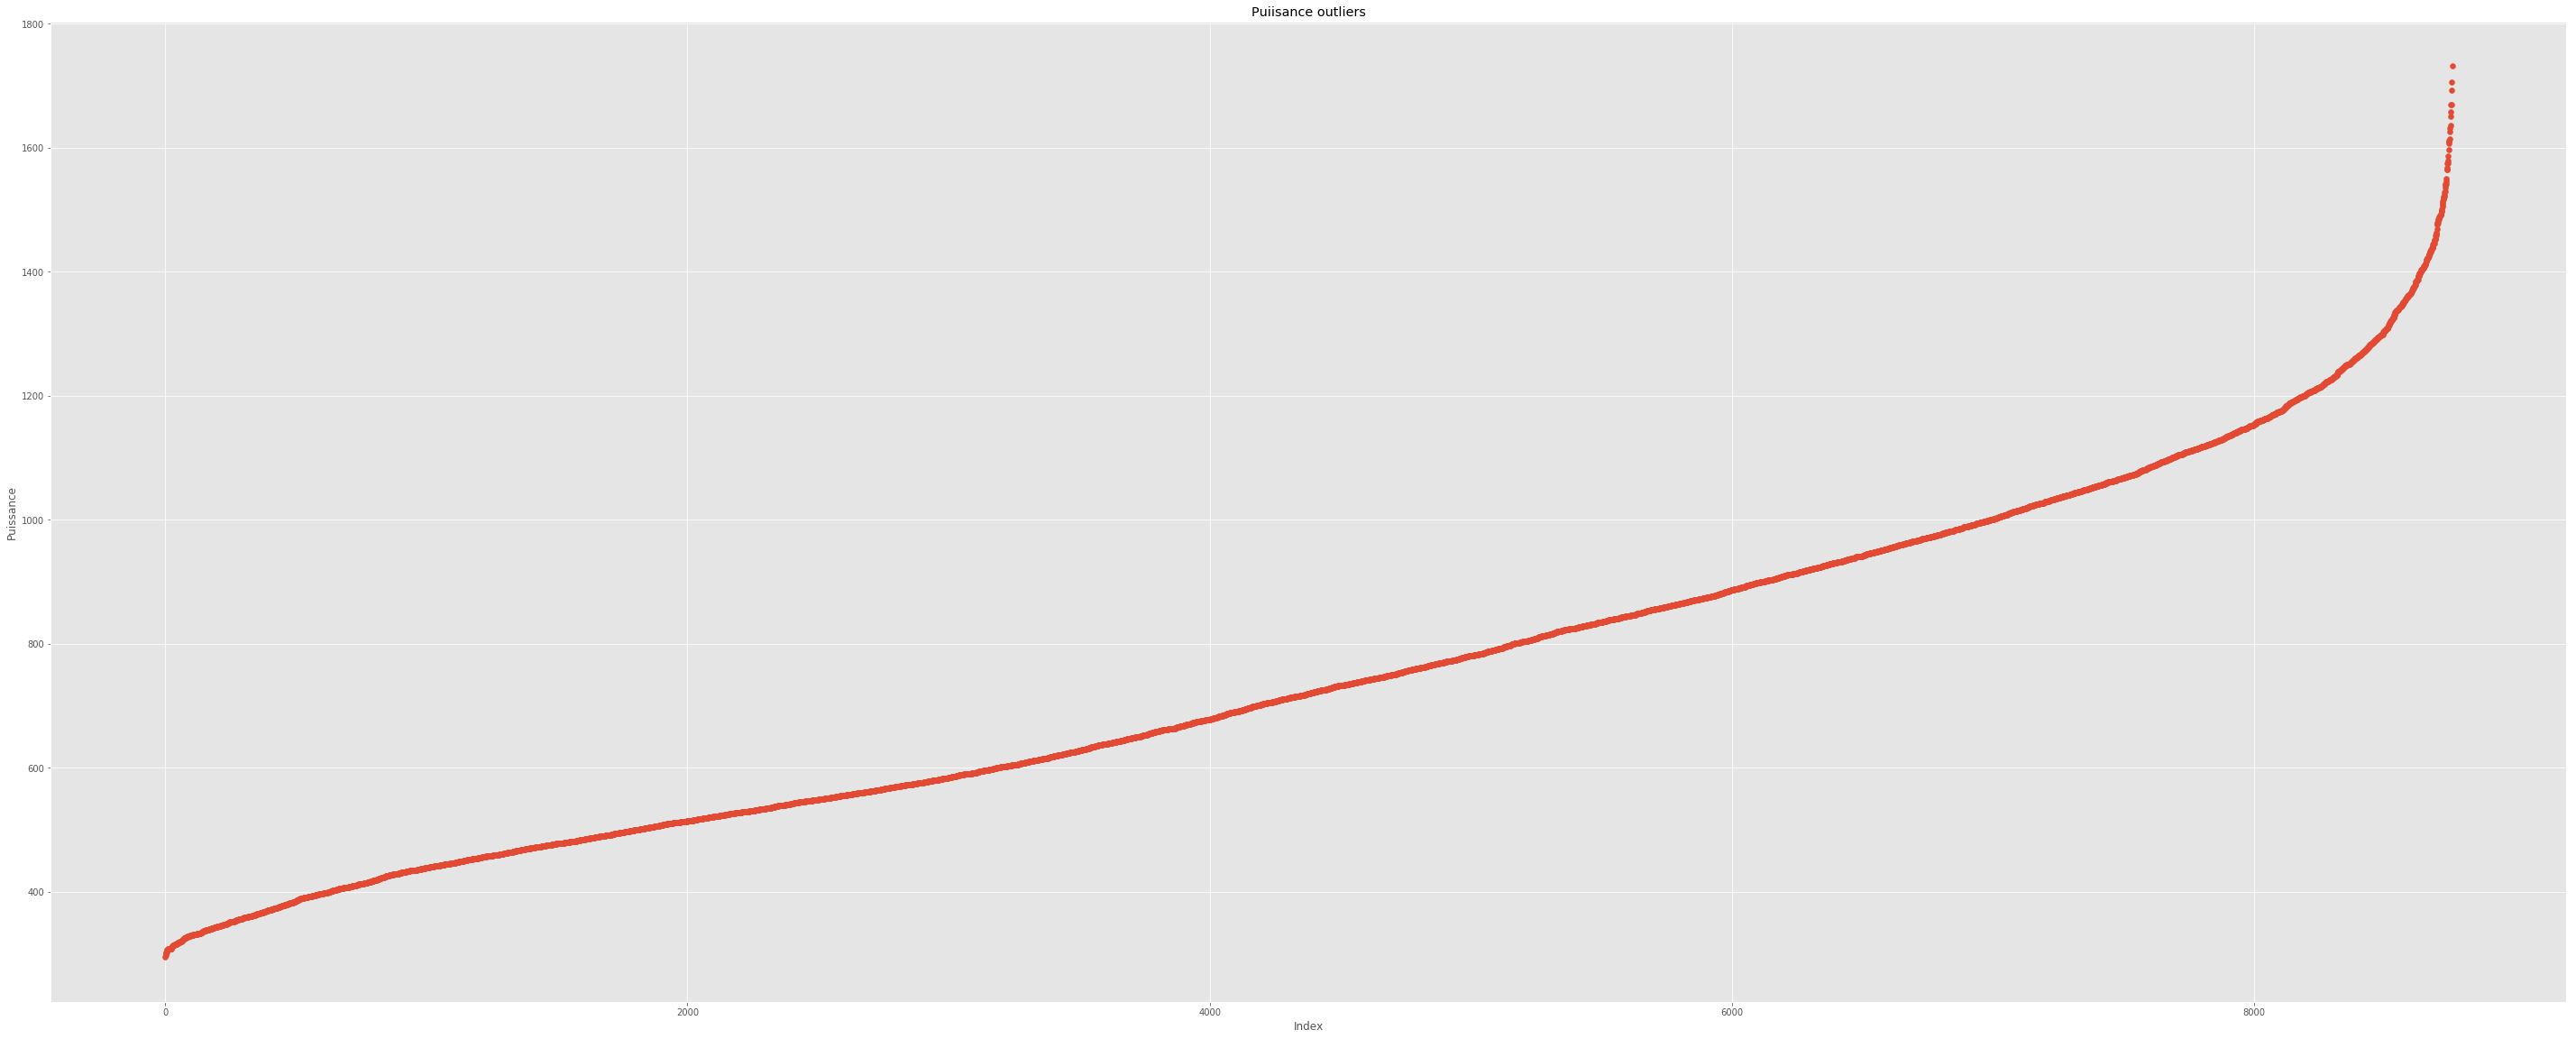

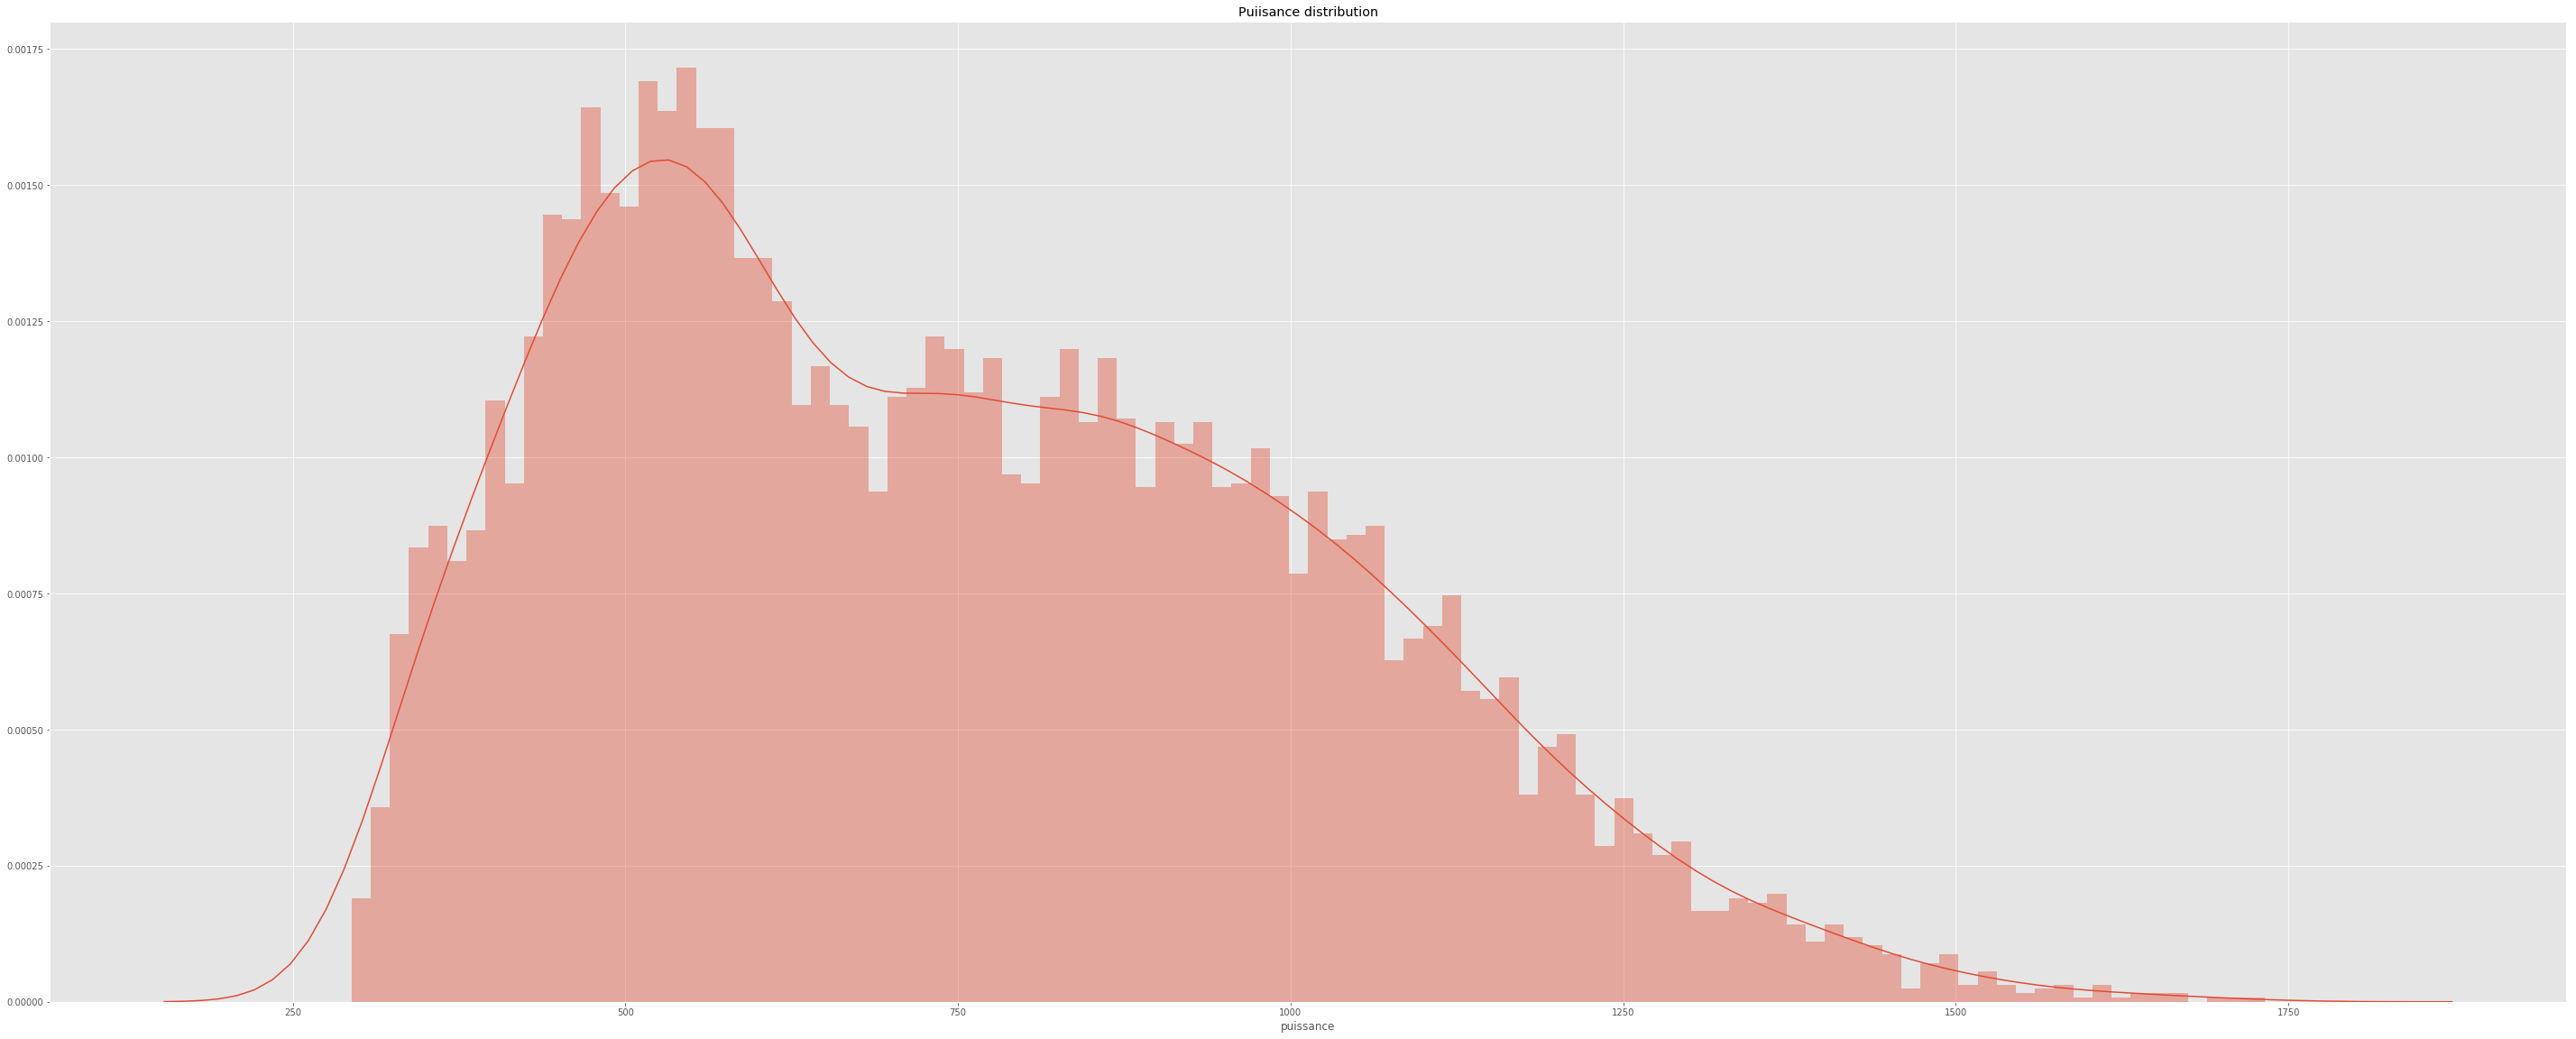

In [2]:
# Display the times series
train_conso_plot.plot(figsize=(50,20), title = "Puissance")
plt.show()

# Chack the outliers
plt.figure(figsize=(50,20))
plt.scatter(range(train_conso_plot.shape[0]), np.sort(train_conso_plot.puissance.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Puissance', fontsize=12)
plt.title("Puiisance outliers")
plt.show()

# Display the distribution
plt.figure(figsize=(50,20))
sns.distplot(pd.DataFrame(train_conso_plot.puissance.values), bins=100)
plt.xlabel('puissance', fontsize=12)
plt.title("Puiisance distribution")
plt.show()

In [3]:
train_conso_plot.puissance.skew()

0.503926934982711

Ces premiers graphiques nous permettent de voir à quoi ressemble la série temporelles (puissance). Nous remarquons aisement qu'il y a une corrélation entre le mois et la puissance consommé. Nous verifierons cela de manière analytique par la suite. Il est tout à fait logique de poser l'hypothèse qu'il y ait une saisonnalité annuelle de la consommation de puissance. En hiver la consommation est bien plus élevé qu'en été. Le second graphique qu'on trouve quelques valeurs plutot élévé mais rien d'alarmant du coté des outliers. Pour finir la dernier graphique nous montre la distribution de la variable puissance. Le coefficient d'asymétrie (ainsi que l'affichage de la distribution) indique une distribution décalée à gauche de la médiane, et donc une queue de distribution étalée vers la droite.

In [4]:
train_conso_plot.reset_index(drop=True, inplace = True)

In [5]:
train_conso['year'] = pd.to_datetime(train_conso['date']).apply(lambda x: x.year)
train_conso['month'] = pd.to_datetime(train_conso['date']).apply(lambda x: x.month)
train_conso['day'] = pd.to_datetime(train_conso['date']).apply(lambda x: x.day)
train_conso['hour'] = pd.to_datetime(train_conso['date']).apply(lambda x: x.hour)

Pour terminer sur cette partie nous allons utiliser la data afin d'extraire certaines informations qui nous permettrons de réaliser la jointure entre les deux fichiers. Pour cela nous réalisons l'extraction de l'annér, du mois, du jours et de l'heure. Nous passons d'un format peu exploitable (date) à 4 variables exploitable pour la jointure et nos futurs modèles prédictifs.

In [6]:
train_conso.head()

,date,puissance,year,month,day,hour
0,2015-09-13T00:59:59,526.166667,2015,9,13,0
1,2015-09-13T01:59:59,495.000000,2015,9,13,1
2,2015-09-13T02:59:59,446.166667,2015,9,13,2
3,2015-09-13T03:59:59,365.833333,2015,9,13,3
4,2015-09-13T04:59:59,341.000000,2015,9,13,4


le fichier conso_2011_2016.csv comporte la puissance consommé par maille horaire de 2011 à aujourd'hui. Nous allons utilisé ces informations afin d'ajouter de nouvelles variables. Les variables utilisées seront la puissance cosommé le meme mois, meme jour et meme heure en 2011 - 2012 - 2013 et 2014. Cette donnée à été récupéré via: https://opendata-iles-ponant.edf.fr/pages/home/

In [7]:
# Import consumption (y_train)
histo_conso = pd.read_csv('conso_2011_2016.csv',sep = ";")
histo_conso['date'] = histo_conso['date'].apply(lambda x: x.split('+')[0])
histo_conso.drop_duplicates(inplace = True)

histo_conso['year'] = pd.to_datetime(histo_conso['date']).apply(lambda x: x.year)
histo_conso['month'] = pd.to_datetime(histo_conso['date']).apply(lambda x: x.month)
histo_conso['day'] = pd.to_datetime(histo_conso['date']).apply(lambda x: x.day)
histo_conso['hour'] = pd.to_datetime(histo_conso['date']).apply(lambda x: x.hour)

histo_out = pd.merge(histo_conso[histo_conso['year'] == 2011], histo_conso[histo_conso['year'] == 2012], how='left', on=["month","day","hour"])
histo_out = pd.merge(histo_out, histo_conso[histo_conso['year'] == 2013], how='left', on=["month","day","hour"])
histo_out = pd.merge(histo_out, histo_conso[histo_conso['year'] == 2014], how='left', on=["month","day","hour"])
histo_out.drop(['date','date_x','year_x','date_y','year_y','year'], axis = 1, inplace = True)
histo_out.columns = ['puissance_1','month','day','hour','puissance_2','puissance_3','puissance_4']
histo_out.drop_duplicates(inplace = True)

# EDA - Meteo 

A travers cette seconde analyse exploratoire nous allons nous tourner vers le second fichier (meteo.csv). Pour rappel: ce fichier comporte un an de données météorologiques à la maille tri-horaire, issues de la proche station météorologique de Brest. Nous retrouver 12 variables:
    - Date: Date à laquel le relevé est fait
    - Temp: La température
    - Press: La pression atmospherique
    - HR: Information concernant l'humidité?
    - Pros: ?
    - Visi: Information concernant la visibilité
    - Vtmean, Vtraf, Vtdir: Variables concernant le vent
    - RR3: ?
    - Neige: Quantité de neige
    - Nebul: ?  
NB: Nous allons pouvoir utiliser la colonne Date afin de realiser du feature engineering.

## Missing values

In [8]:
meteo = pd.read_csv('meteo_train.csv',sep = ";")
meteo_pred = pd.read_csv('meteo_prev.csv', sep = ";")
meteo.drop_duplicates(inplace = True)
meteo.columns = ['Date','Temp',"Press","HR","Pros","Visi","Vtmean","Vtraf","Vtdir","RR3","Neige","Nebul"]
meteo_pred.columns = ['Date','Temp',"Press","HR","Pros","Visi","Vtmean","Vtraf","Vtdir","RR3","Neige","Nebul"]
meteo.head()

,Date,Temp,Press,HR,Pros,Visi,Vtmean,Vtraf,Vtdir,RR3,Neige,Nebul
0,13/09/15 00h00,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0
1,13/09/15 03h00,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0
2,13/09/15 06h00,12.3,1004.7,82.0,9.3,40.0,14.816,22.224,130.0,NaN,NaN,7.0
3,13/09/15 09h00,14.2,1002.9,80.0,10.8,40.0,18.520,31.484,140.0,NaN,NaN,7.0
4,13/09/15 12h00,13.3,1000.8,93.0,12.2,4.0,18.520,38.892,140.0,4.0,NaN,7.0


Il est nécessaire de réaliser une petite analyse concernant les valeurs manquantes. Nous voyons que sur les 5 premières lignes au moins 2 variables possèdent des valeurs manquantes. Il est nécessaire de quantifier cela afin de pouvoir traiter cela de la meilleure manière.

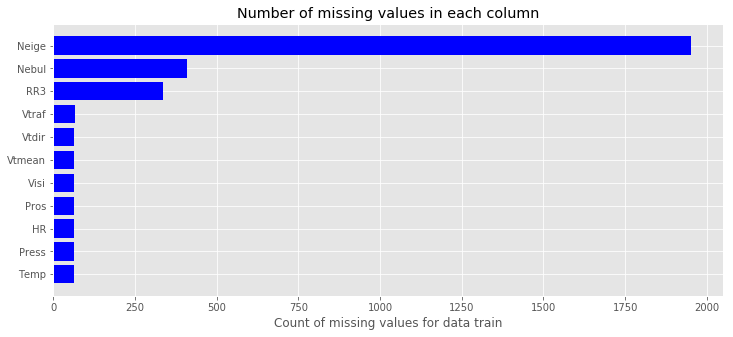

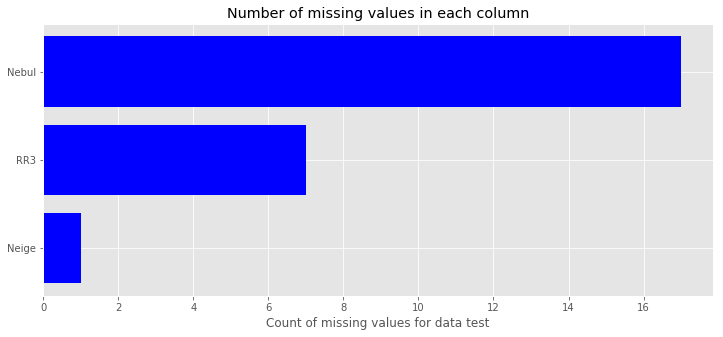

In [9]:
missing_df = meteo.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

missing_df_pred = meteo_pred.isnull().sum(axis=0).reset_index()
missing_df_pred.columns = ['column_name', 'missing_count']
missing_df_pred = missing_df_pred.ix[missing_df_pred['missing_count']>0]
missing_df_pred = missing_df_pred.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,5))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values for data train")
ax.set_title("Number of missing values in each column")
plt.show()

ind = np.arange(missing_df_pred.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,5))
rects = ax.barh(ind, missing_df_pred.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df_pred.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values for data test")
ax.set_title("Number of missing values in each column")
plt.show()

On remarque que pour le jeux de données train beaucoup de variables possèdent des valeurs manquantes. 3 variables possédant le plus de valeurs manquantes sont Neige, Nebul et RR3. En ce qui concerne notre jeux de données test il y a très peu de valeur de manquantes et seul les variables Nebil, RR3 et Neige possède des valeurs manquantes. 

In [10]:
dtype_df = meteo.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,11
1,object,1


In [11]:
missing_df = meteo.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = round((missing_df['missing_count'] / meteo.shape[0])*100)
missing_df

,column_name,missing_count,missing_ratio
0,Date,0,0.0
1,Temp,64,2.0
2,Press,64,2.0
3,HR,64,2.0
4,Pros,64,2.0
5,Visi,64,2.0
6,Vtmean,64,2.0
7,Vtraf,67,2.0
8,Vtdir,64,2.0
9,RR3,336,12.0


On décompte 67% de valeurs manquantes sur la variable Neige, 14% sur la variable Nebul et 12% sur la variable RR3 sur le jeux de données train.

In [12]:
missing_df_pred = meteo_pred.isnull().sum(axis=0).reset_index()
missing_df_pred.columns = ['column_name', 'missing_count']
missing_df_pred['missing_ratio'] = round((missing_df_pred['missing_count'] / meteo_pred.shape[0])*100)
missing_df_pred

,column_name,missing_count,missing_ratio
0,Date,0,0.0
1,Temp,0,0.0
2,Press,0,0.0
3,HR,0,0.0
4,Pros,0,0.0
5,Visi,0,0.0
6,Vtmean,0,0.0
7,Vtraf,0,0.0
8,Vtdir,0,0.0
9,RR3,7,11.0


On décompte 2% de valeurs manquantes sur la variable Neige, 26% sur la variable Nebul et 11% sur la variable RR3 sur le jeux de données train.

In [13]:
meteo['year'] = pd.to_datetime(meteo['Date'], dayfirst=True).apply(lambda x: x.year)
meteo['month'] = pd.to_datetime(meteo['Date'], dayfirst=True).apply(lambda x: x.month)
meteo['day'] = pd.to_datetime(meteo['Date'], dayfirst=True).apply(lambda x: x.day)
meteo['hour'] = pd.to_datetime(meteo['Date'], dayfirst=True).apply(lambda x: x.hour)

meteo_pred['year'] = pd.to_datetime(meteo_pred['Date'], dayfirst=True).apply(lambda x: x.year)
meteo_pred['month'] = pd.to_datetime(meteo_pred['Date'], dayfirst=True).apply(lambda x: x.month)
meteo_pred['day'] = pd.to_datetime(meteo_pred['Date'], dayfirst=True).apply(lambda x: x.day)
meteo_pred['hour'] = pd.to_datetime(meteo_pred['Date'], dayfirst=True).apply(lambda x: x.hour)

meteo.head()

,Date,Temp,Press,HR,Pros,Visi,Vtmean,Vtraf,Vtdir,RR3,Neige,Nebul,year,month,day,hour
0,13/09/15 00h00,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0,2015,9,13,0
1,13/09/15 03h00,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0,2015,9,13,3
2,13/09/15 06h00,12.3,1004.7,82.0,9.3,40.0,14.816,22.224,130.0,NaN,NaN,7.0,2015,9,13,6
3,13/09/15 09h00,14.2,1002.9,80.0,10.8,40.0,18.520,31.484,140.0,NaN,NaN,7.0,2015,9,13,9
4,13/09/15 12h00,13.3,1000.8,93.0,12.2,4.0,18.520,38.892,140.0,4.0,NaN,7.0,2015,9,13,12


Pour la suite de l'analyse nous allons assembler les 2 fichiers. Cependant le fichier météo est sur une maille tri-horaire tandis que le second est sur une maille horaire. Il est donc nécessaire de le retravailler afin de pouvoir réaliser une joiture en l'année, le mois, le jour et l'heure.

In [14]:
# join the record hour 0 with 0-1-2 , 3 with 3-4-5 and so on
train_conso.ix[train_conso.hour < 3, "hour"] = 0
train_conso.ix[(train_conso.hour > 2) & (train_conso.hour < 6),   "hour"] = 3
train_conso.ix[(train_conso.hour > 5) & (train_conso.hour < 9),   "hour"] = 6
train_conso.ix[(train_conso.hour > 8) & (train_conso.hour < 12),  "hour"] = 9
train_conso.ix[(train_conso.hour > 11) & (train_conso.hour < 15), "hour"] = 12
train_conso.ix[(train_conso.hour > 14) & (train_conso.hour < 18), "hour"] = 15
train_conso.ix[(train_conso.hour > 17) & (train_conso.hour < 21), "hour"] = 18
train_conso.ix[(train_conso.hour > 20) & (train_conso.hour < 24), "hour"] = 21

In [15]:
train_merge = pd.merge(train_conso, meteo, how='left', on=["year","month","day","hour"])
# Suppresion du 13 septembre dans les donnée de train
train_merge = train_merge[:-1]
train_merge

,date,puissance,year,month,day,hour,Date,Temp,Press,HR,Pros,Visi,Vtmean,Vtraf,Vtdir,RR3,Neige,Nebul
0,2015-09-13T00:59:59,526.166667,2015,9,13,0,13/09/15 00h00,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0
1,2015-09-13T01:59:59,495.000000,2015,9,13,0,13/09/15 00h00,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0
2,2015-09-13T02:59:59,446.166667,2015,9,13,0,13/09/15 00h00,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0
3,2015-09-13T03:59:59,365.833333,2015,9,13,3,13/09/15 03h00,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0
4,2015-09-13T04:59:59,341.000000,2015,9,13,3,13/09/15 03h00,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0
5,2015-09-13T05:59:59,352.333333,2015,9,13,3,13/09/15 03h00,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0
6,2015-09-13T06:59:59,374.833333,2015,9,13,6,13/09/15 06h00,12.3,1004.7,82.0,9.3,40.0,14.816,22.224,130.0,NaN,NaN,7.0
7,2015-09-13T07:59:59,459.166667,2015,9,13,6,13/09/15 06h00,12.3,1004.7,82.0,9.3,40.0,14.816,22.224,130.0,NaN,NaN,7.0
8,2015-09-13T08:59:59,555.500000,2015,9,13,6,13/09/15 06h00,12.3,1004.7,82.0,9.3,40.0,14.816,22.224,130.0,NaN,NaN,7.0
9,2015-09-13T09:59:59,684.166667,2015,9,13,9,13/09/15 09h00,14.2,1002.9,80.0,10.8,40.0,18.520,31.484,140.0,NaN,NaN,7.0


## Correlation

Maintenant que nous avons assemblé les deux fichiers il va être possible de réaliser une étude de corrélation entre nos variables explicatives et notre variable à expliquer. Puis nous étudierons la corrélation entre variables explicatives. La corrélation étudié dans notre cas sera la corréaltion de Pearson (corrélation linéaire).

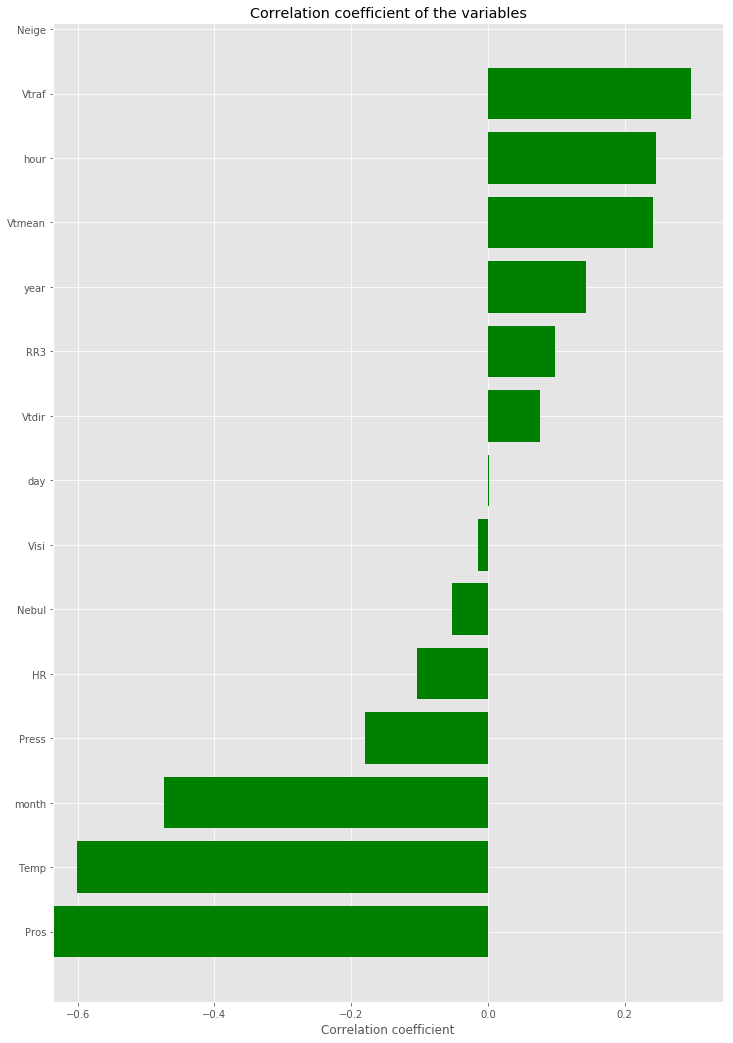

In [16]:
# UNIVARIATE STYLE
mean_values = train_merge.median(axis=0)
train_df_new = train_merge.fillna(mean_values, inplace=True)

x_cols = [col for col in train_df_new.columns if col not in ['puissance'] if train_df_new[col].dtype != 'object']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.puissance.values)[0,1])
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='g')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

Les corrélations linéaires les plus élevés en valeur absolu respectivement pour les variables: pros, temp, month, hour, vtraf et vtmean. la variable day possède une corrélation linéaire quasiment nulle avec notre variable à expliquer. Nous décidons de remplacer les valeurs manquantes par la médiane des variables en question.

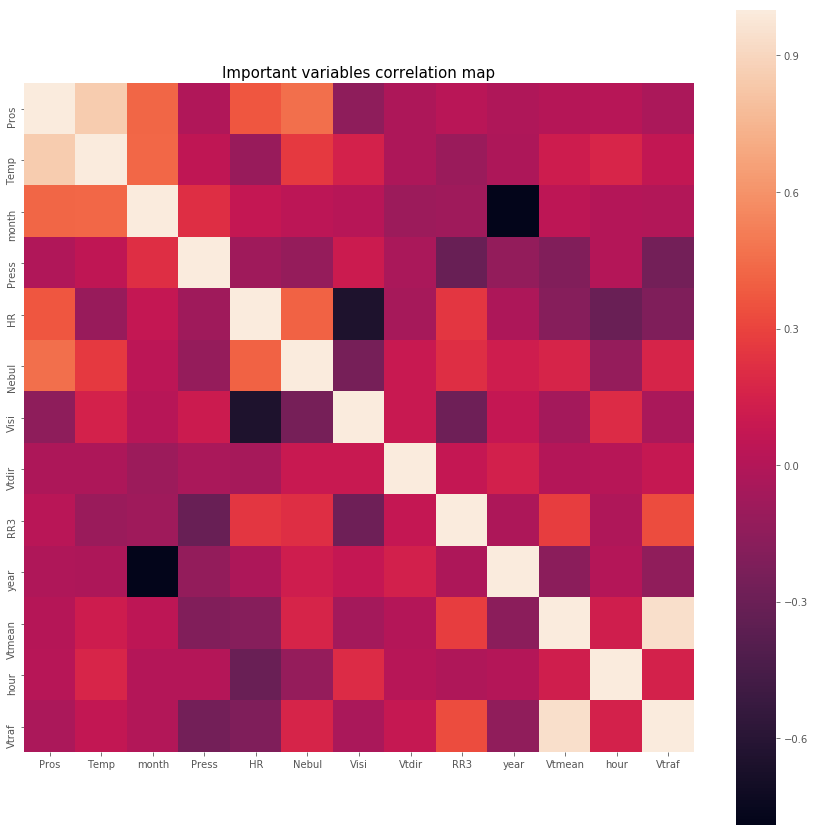

In [17]:
# Selection of features
mean_values_pred = meteo_pred.median(axis=0)
test_df_new = meteo_pred.fillna(mean_values_pred, inplace=True)
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]

cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_merge[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(15, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

Pour terminer sur cette analyse des corrélations nous continuons avec une dernière heatmap permettant de représenter de façon matricielle les corrélations entre nos variables explicatives. On remarque une forte corrélation (négative) entre HR et visi.

## Jointplot

La visualisation via jointplot (seaborn) permet d'avoir à la fois un graphe pour une étude bivariée mais aussi l'affichage des graph pour une étude univarié. Ces graphiques croisent les variables temp (température) é puissance et Pros & Puissance. On remarque deux chose: un ensemble de points sont alignés et les points sont moins éparpillés lorsque la température ou le Pros est plus élevé.
Nous pouvons en tirer 2 conclusions: Un enemble de valeurs de température et Pros apparaissent de nombreuses fois dans notre jeux de données et la puissance sera plus facile à prédire au delà de 20 degré ou avec un Pros elevé. NB: La heatmap précédente montre une forte corrélation entre Temp et Pros.

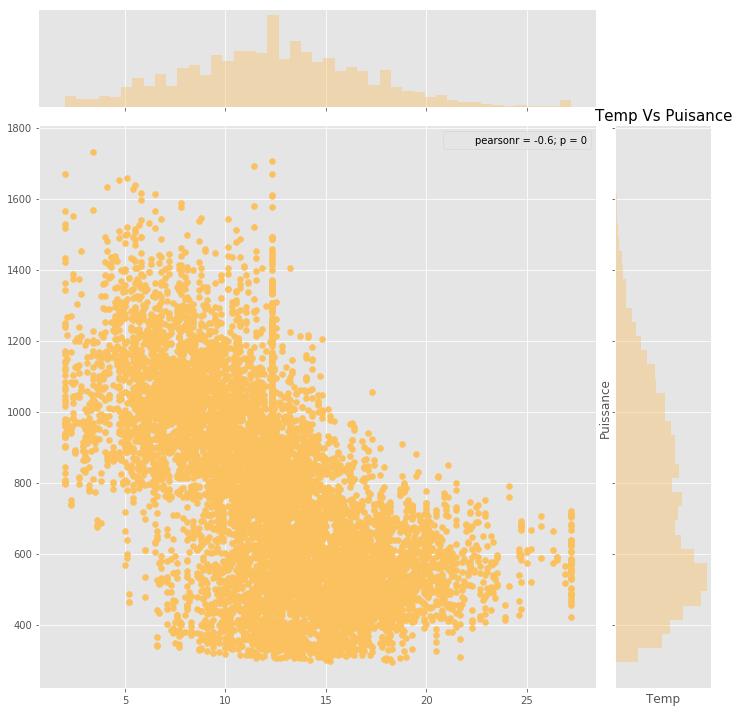

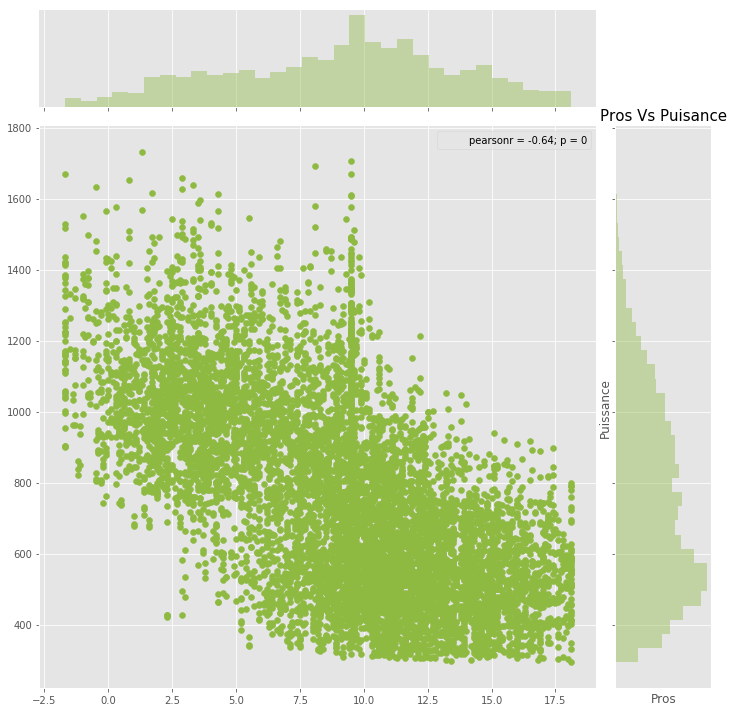

In [18]:
col = "Temp"
ulimit = np.percentile(train_merge[col].values, 99.5)
llimit = np.percentile(train_merge[col].values, 0.5)
train_merge[col].ix[train_merge[col]>ulimit] = ulimit
train_merge[col].ix[train_merge[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_merge.Temp.values, y=train_merge.puissance.values, size=10, color=color[4])
plt.ylabel('Puissance', fontsize=12)
plt.xlabel('Temp', fontsize=12)
plt.title("Temp Vs Puisance", fontsize=15)
plt.show()

col = "Pros"
ulimit = np.percentile(train_merge[col].values, 99.5)
llimit = np.percentile(train_merge[col].values, 0.5)
train_merge[col].ix[train_merge[col]>ulimit] = ulimit
train_merge[col].ix[train_merge[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_merge.Pros.values, y=train_merge.puissance.values, size=10, color=color[5])
plt.ylabel('Puissance', fontsize=12)
plt.xlabel('Pros', fontsize=12)
plt.title("Pros Vs Puisance", fontsize=15)
plt.show()

## Boxplot

A travers cette partie nous allons pouvoir visualiser si il existe des outliers et l'information fournie par l'étendue, ainsi que par les trois quartiles et les intervalles qui les séparent. Comme exposé précédemment on remarque que sur les période d'été (période avec température élevé) les boxplot sont beaucoup moins étendus et l'on trouve beaucoup moins de valeurs sortant de l'ordinaire.

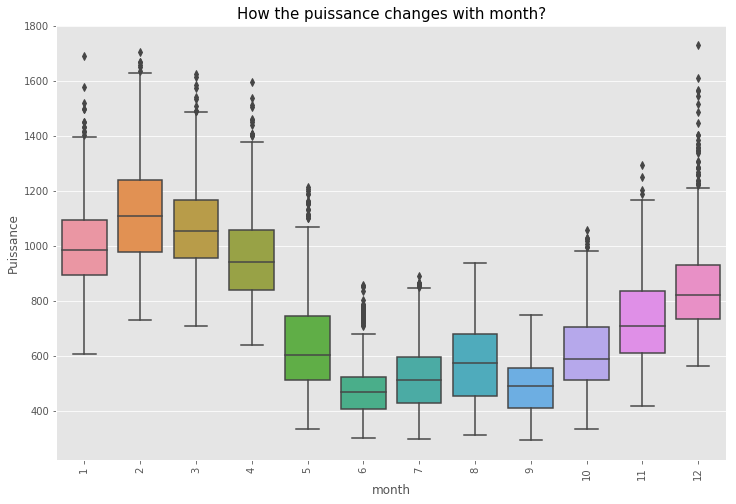

In [19]:
plt.figure(figsize=(12,8))
sns.boxplot(x="month", y="puissance", data=train_merge)
plt.ylabel('Puissance', fontsize=12)
plt.xlabel('month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How the puissance changes with month?", fontsize=15)
plt.show()

# First Prediction - Quick & Dirty (Tabular Approach)

Le but de cette partie n'est pas forcément d'avoir le meilleur modèle mais d'avoir une première idée des variables qui permettront de prédire notre variable à expliquer. Pour cela nous utilisons 1 modèle: ExtrTreesRegressor (apprécié pour sa couche d'aléatoire permettant d'éviter l'overfitting). Les modèles lineaires ne fournissant pas de bons résultats (forte importance de la variable month) car la donnée n'est pas adequat à ce type de modèle ne seront pas utilisées dans cette partie. Afin de pouvoir utiliser un modèle il aurait été necessaire de retrvailler les variables et donc de prendre plus de temps (en retravaillant month)...

In [20]:
train_y = train_merge['puissance'].values
train_merge = train_merge.drop(['puissance','date','Date'], axis=1)

feat_names = train_merge.columns.values

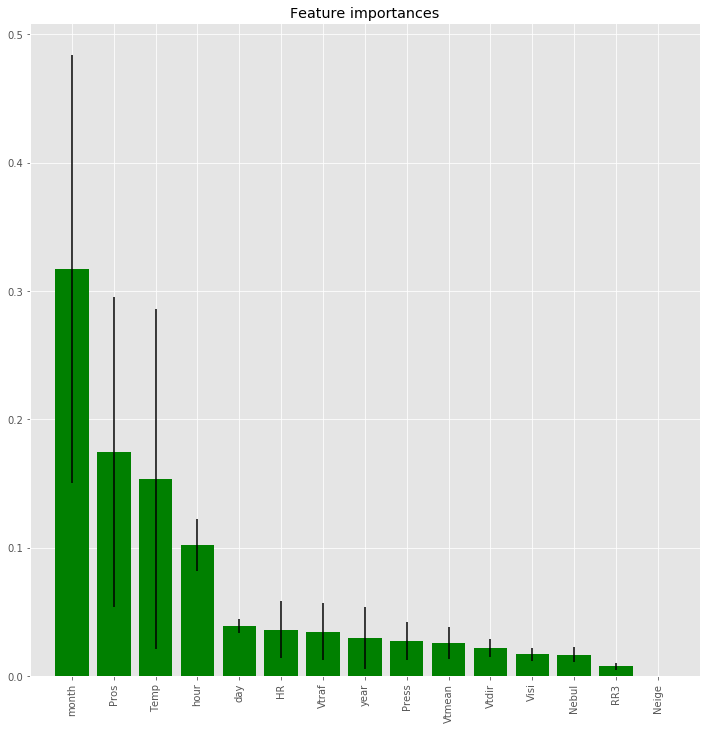

In [21]:
model = ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_merge, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="green", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Ce premier modèle nous indique que la variable month possède une place importante dans la prédiction de la puissance. Ce que nous avions déjà deviné en amont. Les variables Pros & Temps arrivent juste après. Ce qui parait logique puisque l'on peut emettre l'hypothèse que durant les journées chaudes (d'été de de printemps) la puissance necessaire et consommé est moindre que durant les journées froides d'hiver. Enfin l'heure arrive en quatrième position. Nous avions aussi deviné que cette variable allait jouer un rôle important.

# Second Prediction - Deep Learning Approach

Dans cette partie nous avons voulu revenir sur la partie série temporelle afin d'en faire une analyse un peu plus poussée. Le but étant de proposer une approche deep learning concentré sur la série temporelle. Sur le tabular data ce n'est pas forcément necessaire, les modèles de boosting surperforme de façon systématique.

### Time Series Analytics 

Afin de réaliser notre anylyse de la série temporelle nous allons tout d'abord voir si il ne manque pas de valeur dans notre série temporelle qui est censé être sur une maille horaire.

In [22]:
df = train_conso[['date','puissance']]
df['date'] = pd.to_datetime(df['date'])

numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

time_column = df[date_columns[0]]
df.set_index(time_column, inplace=True)
df.sort_index(ascending=True, inplace=True)

In [23]:
sample_freq = "1H"
df_interpolate = df.resample(sample_freq, label="left", convention="e").median()
df_interpolate = df_interpolate.interpolate(method="time")
print("Number of interpolations: %s" % (df.shape[0] - df_interpolate.shape[0]))

Number of interpolations: -26


A priori il manquerait 26 relevé de la puissance dans notre fichier. Nous décidons de les remplacer par la médiane. Afin de faire apparaitre la tendance nous allons afficher les séries temporelles moyennes mobiles avec la liste de fenetres suviante: [12,24,48,72,96]. Meme si cela est plutot évident dans notre cas cela reste toujours interessant.

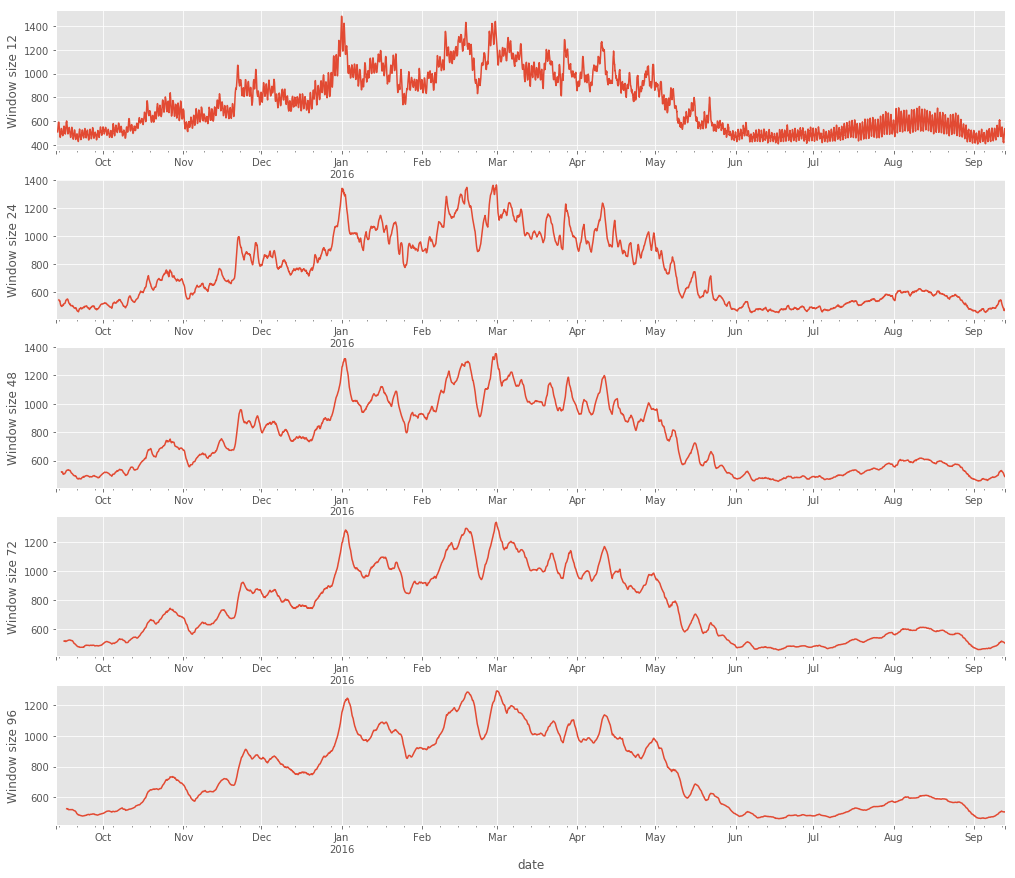

In [24]:
series_column = numerical_columns[0]
df_col = df_interpolate[series_column]
window_widths = [12,24,48,72,96]

f, ax = plt.subplots(len(window_widths), figsize=(17, 3 * len(window_widths)))
for (i, window_size) in enumerate(window_widths):
    ax[i].set_ylabel("Window size %s" % window_size)
    pd.Series.rolling(df_col, window=window_size, center=False).mean().plot(ax=ax[i])

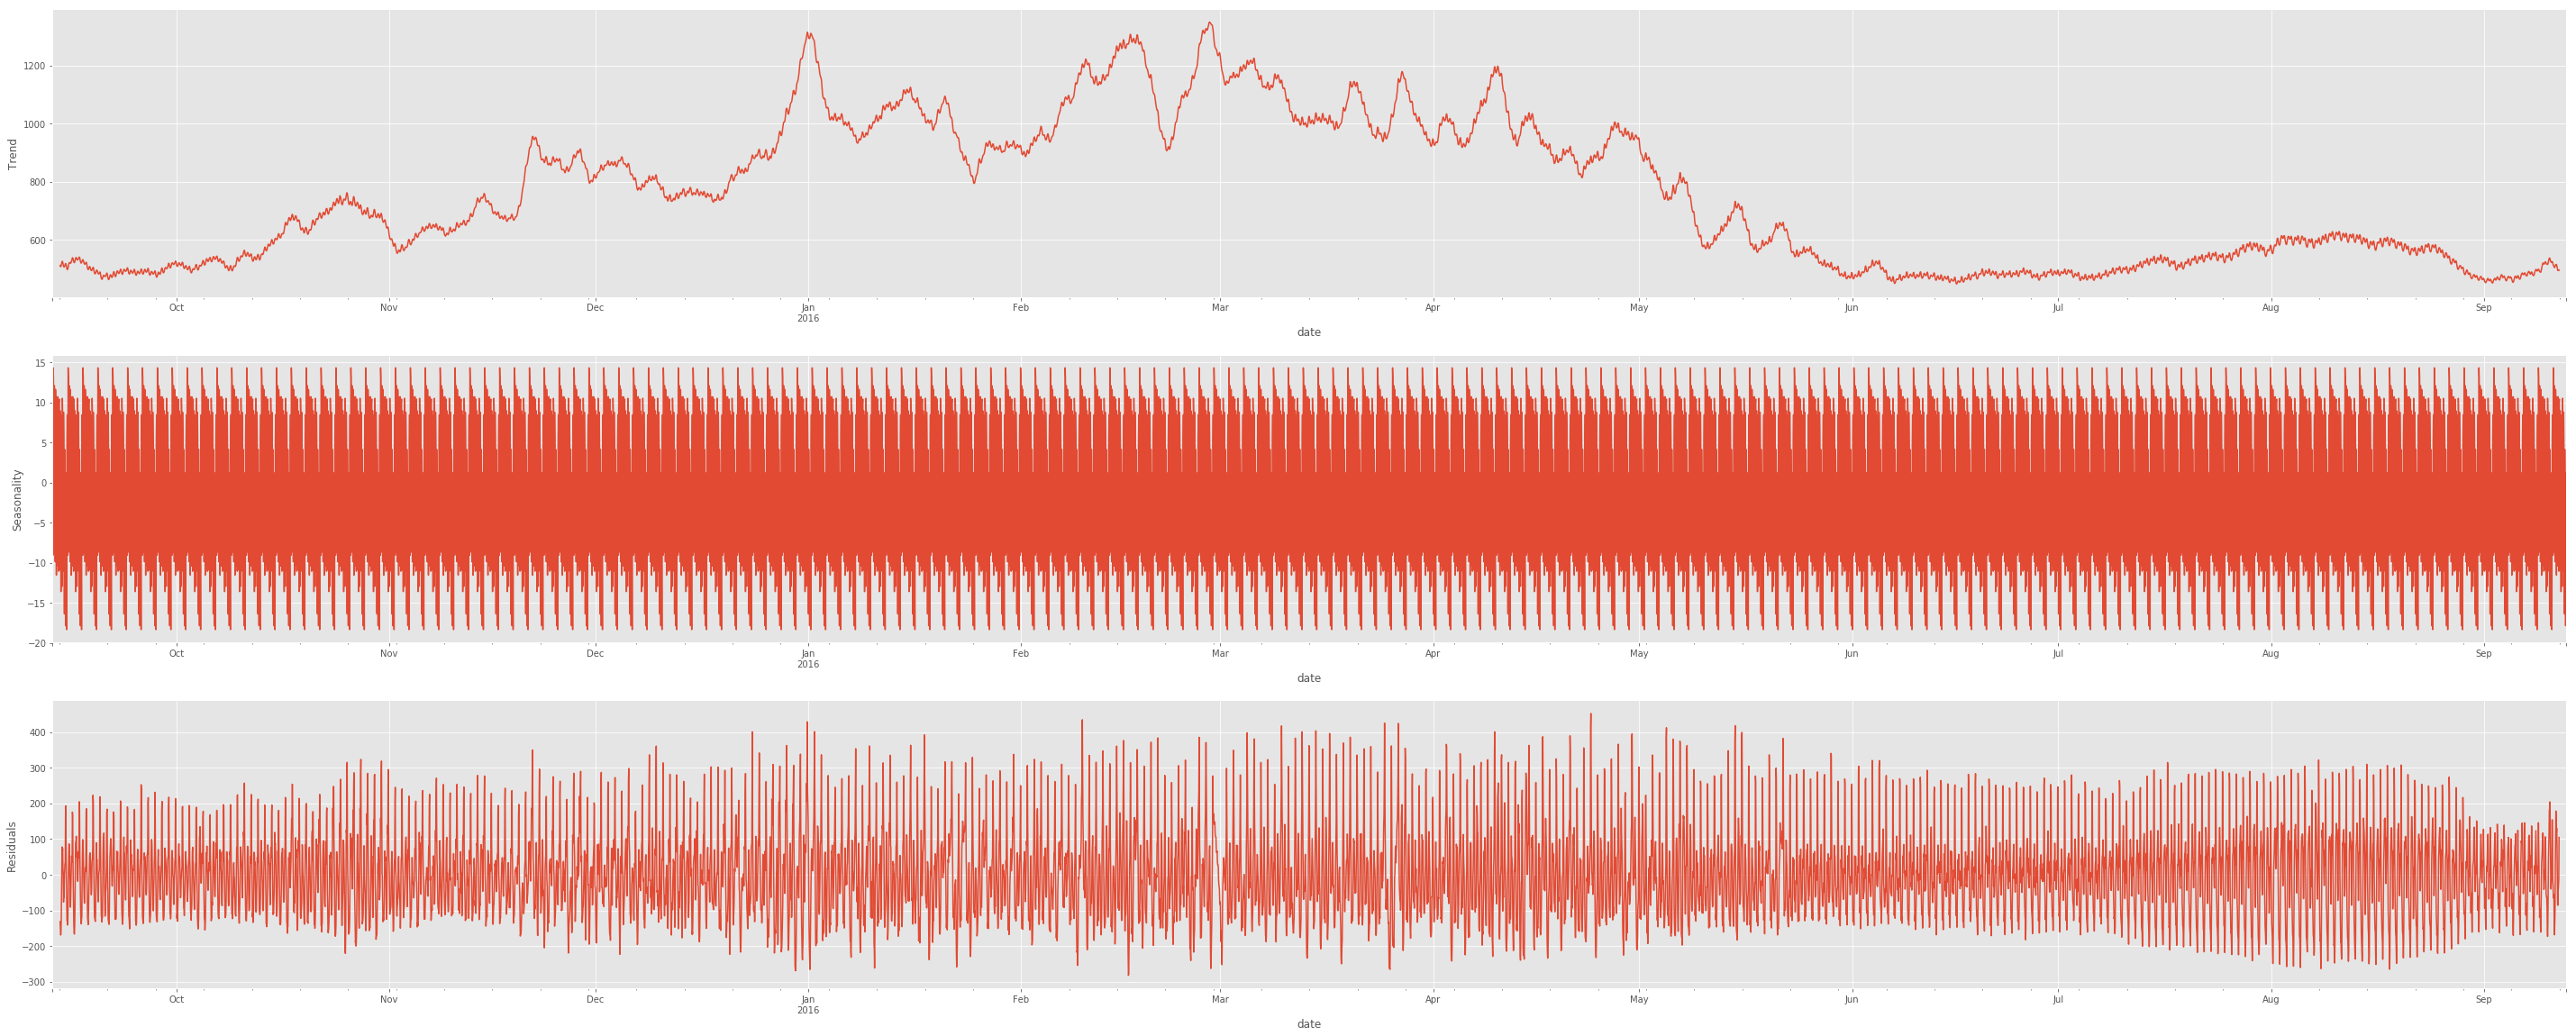

In [25]:
# The number of samples you want to use as timescale for the seasonality decomposition
if sample_freq == "1W":
    freq = 52
elif sample_freq == "1M":
    freq = 12
elif sample_freq == "1D":
    freq = 365
else:
    freq = 52 # Change this with a seasonality you think should be present in your data.

df_col_nona = df_col.fillna(method="ffill")

# Decompose time series
decomposition = seasonal_decompose(df_col_nona.values,freq=freq)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
df_stl = pd.DataFrame(index=df_col_nona.index)
df_stl["Trend"] = trend
df_stl["Seasonality"] = seasonal
df_stl["Residuals"] = residual

#Display    
f, ax = plt.subplots(3, figsize=(50, 20))
for (i, col) in enumerate(df_stl.columns):
    ax[i].set_ylabel(col)
    df_stl[col].plot(ax=ax[i])

Pour finir nous décidons de décomposer notre série temporelle. Dans notre cas nous nous sommes contenté d'une décomposition naive. Des décompositions plus sophisitiqués sont à privilégier.
Notre modèle additive est du type: Y[t] = T[t] + S[t] + e[t]. Cette analyse ne sera pas utilisé dans le cadre d'une prédiction. Cependant elle peut etre reprise afin d'utiliser par la suite une approche statistique en vérifiant les hypothéses permettant d'appliquer les modèles. Nous avons préférés nous concentré sur une approche Deep learning avec Tensorflow.

### Recurrent Neural Network

Cette approche ne sera pas utilisé dans le cadre de la soumission de resultats du challenge. Néanmoins elle pourrait être reprise dans le cadre d'une approche ou l'utilisateur n'aurait à dispositon que la série temporelle et serait privé de l'ensemble de la donnée fournit par la station météo. Nous définisson aussi notre metrique qui nous permettra de benchmarker nos modèles tout au long du processus de mise en place du meilleur modèle.

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
df = df.reset_index(drop = True)
date_week = df.date
uuid_brute = df.puissance  
            

TS = np.array(df.puissance)
num_periods = 192

new_pred = []

X_data = np.array([])
Y_data = np.array([])
for indi in range(int(len(TS)/num_periods)):
    alea = random.randint(0,len(TS)-(2*num_periods))
    X_data = np.concatenate((X_data,TS[alea:alea+num_periods]),axis=0)
    Y_data = np.concatenate((Y_data,TS[alea+num_periods:alea+(2*num_periods)]),axis=0)
            
x_batches = X_data.reshape(-1, num_periods,1)
y_batches = Y_data.reshape(-1, num_periods,1)
        
tf.reset_default_graph()

inputs = 1
hidden = 50
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden, activation = tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(outputs,y),y)))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

epochs = 1000
MAPE_output = []

np.random.seed(1337) 

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {X: x_batches, y: y_batches})
        if ep % 100 == 0:
            MAPE = loss.eval(feed_dict = {X: x_batches, y: y_batches})
            MAPE_output.append(MAPE)
            print(MAPE)
    prediction = sess.run(outputs, feed_dict = {X: TS[(len(TS) - num_periods)::][:num_periods].reshape(-1,num_periods,1)})
       
TS_brute = np.array(uuid_brute)
out = np.append(TS_brute, prediction)
        
df_output = pd.DataFrame(out, columns = ['Prediction'])
df_output['Inbound_calls']= list(uuid_brute)+['' for k in range(num_periods)]
df_output['Date'] = list(date_week) + ['date_+{}'.format(k+1) for k in range(num_periods)]

0.8850881
0.113516055
0.11320256
0.10587725
0.10419758
0.10417493
0.104603305
0.10137829
0.10040937
0.10124123


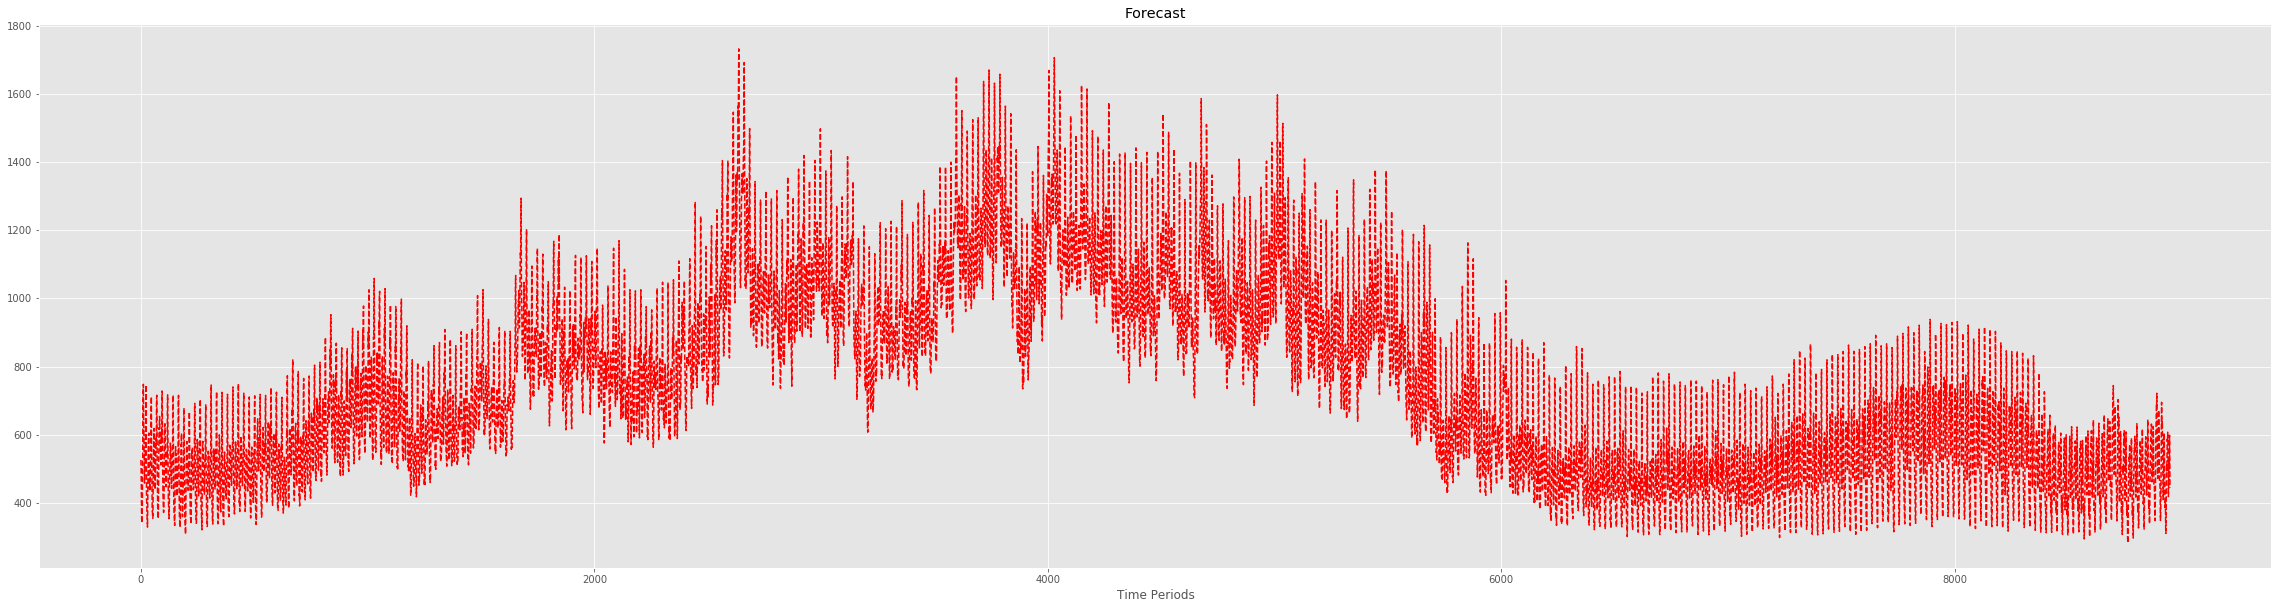

In [28]:
plt.figure(figsize=(40,10))
plt.title('Forecast')
plt.plot(pd.Series(np.ravel(out)), "--r", markersize = 10, label = "Real + Forecast")
plt.xlabel('Time Periods')
plt.show()

Au vue des résultats la MAPE devrait être aux alentours des 10% - 11%. Ce qui n'est pas mauvais pour une approche orienté série temporelle. Pour améliorer notre modèle il serait necessaire de récupérer plus d'historique. 

# Final Prediction - Stacking

L'approche final et que nous soumettons utilise le principe de stacking. Pour cela nous sommes partis sur la mise en place d'un cross validation avec une méthode d'out of bag permettant de stacker nos modèles. Les variables Date et Neige seront supprimés car inutile dans l'implémentation de notre modèle (neige toujours à zéro et Date inexploitable tel quel). Notre modèle sera composé de light GBM, d'Extra trees Regressor, d'HuberRegressor et pour finir nous  utiliserons la médianes des prédictions pour soumettre notre résultats.

La fonction deshuffle permet de remettre dans l'ordre les prédictions qui sont mélanger lors du processus de la cross validation.

Nous ajouterons la variables puissance décalé de 192, 288 et 384 fois la période (maille horaire). De plus nous utiliserons le log de la puissance dans le cadre de la prédiction (permettant d'ajouter de la normalité + reduction du coeffsicient d'asymétrie).

L'ensemble des stack sera illustré via une image permettant de comprendre au mieux l'ensemble du modèle prédictif.

In [29]:
#test_test

In [30]:
# preprocessing
test_df_new.drop(['Date','Neige','Visi','Nebul'], inplace = True, axis = 1)
train_merge.drop(['Neige','Visi','Nebul'], inplace = True, axis = 1)

In [31]:
test_test = test_df_new.append(test_df_new[:-1]).append(test_df_new[:-1]).reset_index(drop = True)
#test_test = test_test[1:]
test_final = test_test.sort_values(by = ['day','hour']).reset_index(drop = True)

test_final = test_final[train_merge.columns]
test_final = test_final[:-1]

In [32]:
# Golden Features
train_merge = train_merge.join(pd.DataFrame(train_y,columns=['shift_power']).shift(192).fillna(0))
test_final = test_final.join(pd.DataFrame(train_y,columns=['shift_power'])[-192:].reset_index(drop = True))

train_merge = train_merge.join(pd.DataFrame(train_y,columns=['shift_power_mid']).shift(288).fillna(0))
test_final = test_final.join(pd.DataFrame(train_y,columns=['shift_power_mid'])[-288:].reset_index(drop = True))

train_merge = train_merge.join(pd.DataFrame(train_y,columns=['shift_power_bis']).shift(384).fillna(0))
test_final = test_final.join(pd.DataFrame(train_y,columns=['shift_power_bis'])[-384:].reset_index(drop = True))

In [33]:
histo_out.drop_duplicates(subset = ['month','day','hour'], inplace = True)

test_final = pd.merge(test_final, histo_out, on = ['month','day','hour'])
train_merge = pd.merge(train_merge, histo_out, how = 'left', on = ['month','day','hour'])

train_merge['puissance_1'] = train_merge['puissance_1'].fillna(train_merge['puissance_1'].median())
train_merge['puissance_2'] = train_merge['puissance_2'].fillna(train_merge['puissance_2'].median())
train_merge['puissance_3'] = train_merge['puissance_3'].fillna(train_merge['puissance_3'].median())

train_merge.shape

(8758, 19)

In [34]:
def cross_validate(model, dataframe, test_to_score, y, folds = 5, repeats=5):
    '''
    Function to do the cross validation - using stacked Out of Bag method instead of averaging across folds.
    model = algorithm to validate. Must be scikit learn or scikit-learn like API 
    x = training data, numpy array
    y = training labels, numpy array
    folds = K, the number of folds to divide the data into
    repeats = Number of times to repeat validation process for more confidence
    '''
    ypred = np.zeros((len(y),repeats))
    yscored = np.zeros((test_to_score.shape[0],repeats))
    score = np.zeros(repeats)
    index = np.array(dataframe.index)
    index_out = np.zeros((len(y),repeats))
    x = np.array(dataframe)
    
    for r in range(repeats):
        i=0
        x,y = shuffle(x, y, random_state = r) 
        index = shuffle(index, random_state = r)
        index_out[:,r] = index
        kf = KFold(n_splits = folds, random_state = i + 1000)
        for train_ind, test_ind in kf.split(x):
            xtrain, ytrain = x[train_ind,:], y[train_ind]
            xtest, ytest = x[test_ind,:], y[test_ind]
            model.fit(xtrain, ytrain)
            ypred[test_ind,r] = model.predict(xtest) 
            yscored[:,r] = yscored[:,r] + model.predict(test_to_score) 
            i+=1
        yscored[:,r] = yscored[:,r] / folds
        score[r] = mean_absolute_percentage_error(np.exp(y),np.exp(ypred[:,r]))
    print('Mean:',str(np.mean(score)))
    print('Deviation:',str(np.std(score)))
    return ypred, index_out.astype(int), np.mean(score), yscored

def main_l1(train_input = train_merge, rep = 5, test_input = test_final, regressor = lgb.LGBMRegressor()):
    train = train_input.copy()
    y = np.array(train_y)
    y = np.log(y)
    
    xgb_model = regressor
    out, index_out, score_output, yscored = cross_validate(xgb_model, train, test_input, y, folds = 5, repeats = rep)
    
    return out, index_out.astype(int), score_output, yscored

def deshuffled(output_stack_1, index_stack_1, j):
    for i in range(j):
        if i == 0:
            stack_1 = pd.DataFrame(output_stack_1[:,i], index=index_stack_1[:,i])
        if i > 0:
            stack_1 = stack_1.join(pd.DataFrame(output_stack_1[:,i], index=index_stack_1[:,i], columns = [i]))
    stack_1.sort_index(inplace = True)
    return stack_1

def main_l2(train_input = train_merge, test_input = test_final, regressor = Ridge(), rep = 5):
    train = train_input.copy()
    y = np.array(train_y)
    y = np.log(y)
    
    xgb_model = regressor
    out, index_out, score_output, yscored = cross_validate(xgb_model, train_input, test_input, y, folds = 5, repeats = rep)
    
    return out, index_out, score_output, yscored

## Stack 1

In [35]:
# Stack 1
output_lgb, index_hist2, score_1, yscored1  = main_l1(train_input = train_merge, test_input = test_final, regressor = lgb.LGBMRegressor(objective = 'regression', max_depth = 8, num_leaves = 31 + 31*3, metric = 'l2', learning_rate = 0.1/12, n_estimators = 750 ), rep = 6) 

stack_lgb = pd.DataFrame(deshuffled(output_lgb, index_hist2, 6))

Mean: 5.048022824957324
Deviation: 0.0315777813517175


## Stack 2

In [36]:
# Stack 2
output_etr2, index_hist5, score_23, yscored23  = main_l2(train_input = stack_lgb, test_input = pd.DataFrame(yscored1), regressor = ExtraTreesRegressor(max_depth = 6 , n_estimators = 200 + 100*2, n_jobs = -1, random_state = 142 ), rep = 20 )
stack_etr2 = pd.DataFrame(deshuffled(output_etr2, index_hist5, 10))

Mean: 4.890183966354367
Deviation: 0.004457577196555946


## Stack 3

In [37]:
# Stack 3
pd.DataFrame(np.exp(yscored23)).median(axis = 1).to_csv('rickcornichon.csv', index = False)

Le modèle est composé de 6 LightGBM pour la première stack, 20 ExtraTreesRegressor pour la seconde stack et enfin la solution est composé de la médianes de ses 20 ExtraTreesRegressor.